# PyJonas NES pre-process and data model

Goals:
- mock up an xarray to represent the game state
- setup the crops for the different info on the frame
- outline the actual parsing (named tuple)
  - board_state
  - next_piece
  - numerical meta (score, etc.)

## Data model with xarray

In [1]:
from enum import Enum
import cv2
import xarray as xr
import pandas as pd
import numpy as np

class Tetromino(Enum):
    I = 0
    J = 1
    L = 2
    O = 3
    S = 4
    T = 5
    Z = 6

NUM_FRAMES = 30

# Making some fake data, but loading in a bunch of copies of one screen cap used
boards = [np.random.randint(2, size=(20, 10)) for _ in range(NUM_FRAMES)]
# Some fake timestamps for the frames
times = pd.date_range("2000-01-01", periods=NUM_FRAMES)
scores = np.random.randint(10000, size=(NUM_FRAMES, ))
levels = np.random.randint(18, size=(NUM_FRAMES, ))
lines = np.random.randint(100, size=(NUM_FRAMES, ))
next_piece = [Tetromino.J for _ in range(NUM_FRAMES)]

# Using openCV to load the image and convert to grayscale
img = cv2.imread("media/xarray-demo.png")
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

frames = [gray_img for _ in range(NUM_FRAMES)]

# Populating the Dataset
ds = xr.Dataset(
    data_vars={
        "score" : (["time"], scores),
        "level" : (["time"], levels),
        "line" : (["time"], lines),
        "next_piece" : (["time"], next_piece),
        "board" : (["time", "grid_y", "grid_x"], boards),
        "frame" : (["time", "pixel_y", "pixel_x"], frames),
    },
    coords={"time" : times},
    attrs={"player":"Sarah", "skill_level" : "beginner"},
)

In [2]:
ds

<xarray.Dataset>
Dimensions:     (time: 30, grid_y: 20, grid_x: 10, pixel_y: 720, pixel_x: 1280)
Coordinates:
  * time        (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-01-30
Dimensions without coordinates: grid_y, grid_x, pixel_y, pixel_x
Data variables:
    score       (time) int32 1246 3433 9609 3932 1731 ... 1984 1583 9618 632
    level       (time) int32 8 17 14 10 4 7 4 0 7 9 ... 5 17 11 5 6 6 12 6 4 12
    line        (time) int32 80 69 92 35 50 57 49 72 ... 84 68 13 97 10 52 50 66
    next_piece  (time) object Tetromino.J Tetromino.J ... Tetromino.J
    board       (time, grid_y, grid_x) int32 0 1 1 1 1 0 0 0 ... 1 1 1 1 1 0 1 0
    frame       (time, pixel_y, pixel_x) uint8 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1
Attributes:
    player:       Sarah
    skill_level:  beginner

In [3]:
ds.isel(time=5).board

<xarray.DataArray 'board' (grid_y: 20, grid_x: 10)>
array([[1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
       [1, 1, 0, 1, 1, 1, 1, 0, 1, 1],
       [1, 1, 1, 0, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 1, 0, 0, 1, 1, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 1, 0, 1, 0, 1, 1, 0, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 1, 0, 1, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 0, 0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 1, 0],
       [1, 0, 1, 1, 1, 0, 0, 1, 1, 0],
       [1, 0, 1, 1, 0, 0, 0, 0, 1, 0],
       [1, 1, 0, 1, 1, 0, 0, 0, 0, 1],
       [1, 1, 0, 0, 0, 1, 1, 1, 0, 0],
       [0, 1, 1, 0, 1, 0, 0, 1, 0, 1],
       [1, 1, 0, 0, 1, 1, 1, 0, 1, 0],
       [1, 0, 1, 1, 0, 1, 1, 1, 0, 0],
       [1, 1, 0, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 1, 0, 1, 1, 1, 1, 1, 0]])
Coordinates:
    time     datetime64[ns] 2000-01-06
Dimensions without coordinates: grid_y, grid_x

---
## Digitizing frames

In [4]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from collections import namedtuple
%matplotlib inline

In [5]:
img = cv2.imread("media/xarray-demo.png")
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

Bounds = namedtuple("bounds", ["y", "x"]) #OpenCV indexes y first...
Snips = namedtuple("snips",["level", "lines", "score", "board", "next"])
regions = { # ((y1, y2), (x1, x2))
    "board" : Bounds((125, 125 + 504), (495, 495 + 375)),
    "score" : Bounds((173, 173 + 30), (935, 935 + 250)),
    "lines" : Bounds((45, 45 + 35), (755, 755 + 130)),
    "level" : Bounds((500, 500 + 35), (950, 950 + 200)),
    "next" : Bounds((325, 325 + 100),(945, 945 + 150))
}

We can see here that the dimensions of the frame match our expectations:

In [6]:
print({"size": gray_img.size,"shape": gray_img.shape,"type": gray_img.dtype})

{'size': 921600, 'shape': (720, 1280), 'type': dtype('uint8')}


Now we can take the bounds (by inspection) and slice up the original frame into snipets:

In [7]:
frame_snips = Snips(**{key : gray_img[(b.y)[0]:b.y[1],b.x[0]:b.x[1]] for key, b in regions.items()})

Let's make sure they came out alright...

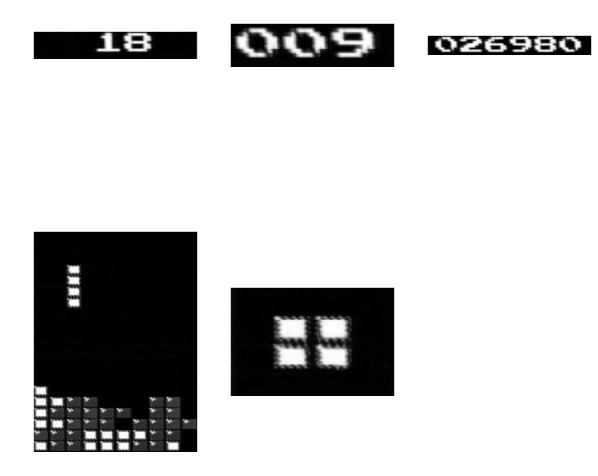

In [8]:
# create figure
fig = plt.figure(figsize=(10, 10))

# setting values to rows and column variables
rows = 2
columns = 3

# looping over the snips to show they worked
for index, key in enumerate(frame_snips._asdict().keys(), start=1):
    fig.add_subplot(rows, columns, index)
    plt.imshow(getattr(frame_snips, key), cmap = 'gray')
    plt.title(key)

### Parse the game board

In [10]:
# Calculate in terms of pixels the size of a mino
mino_size = [int(np.floor(i/j)) for i,j in zip(frame_snips.board.shape,[20,10])]

# We want to find the corrdinates of the center of each mino on the board, so we make a range of samples and offset by half a mino to make it in the center.
y_center = np.linspace(0,frame_snips.board.shape[1], 11, dtype = int) + int(np.floor(mino_size[0]/2))
x_center = np.linspace(0,frame_snips.board.shape[0], 21, dtype = int) + int(np.floor(mino_size[1]/2))

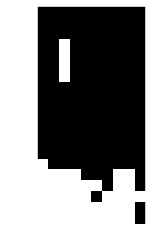

In [11]:
# Returns a 1 if there is a mino at that location, and 0 if not
def has_mino(snip : np.array, x : int, y : int) -> int :
    return int(0 < cv2.inRange(snip, 25,255)[x, y])

# Loop over the board snip and find which points in the (10,20) grid have minos
digital_board = np.array([[has_mino(frame_snips.board, x, y) for y in y_center[:-1]] for x in x_center[:-1]])
plt.imshow(digital_board, cmap = 'gray')

### TODO: Parse the text 

Looking for C:\Users\sarahkaiser\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\sarahkaiser\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 2s 2s/step


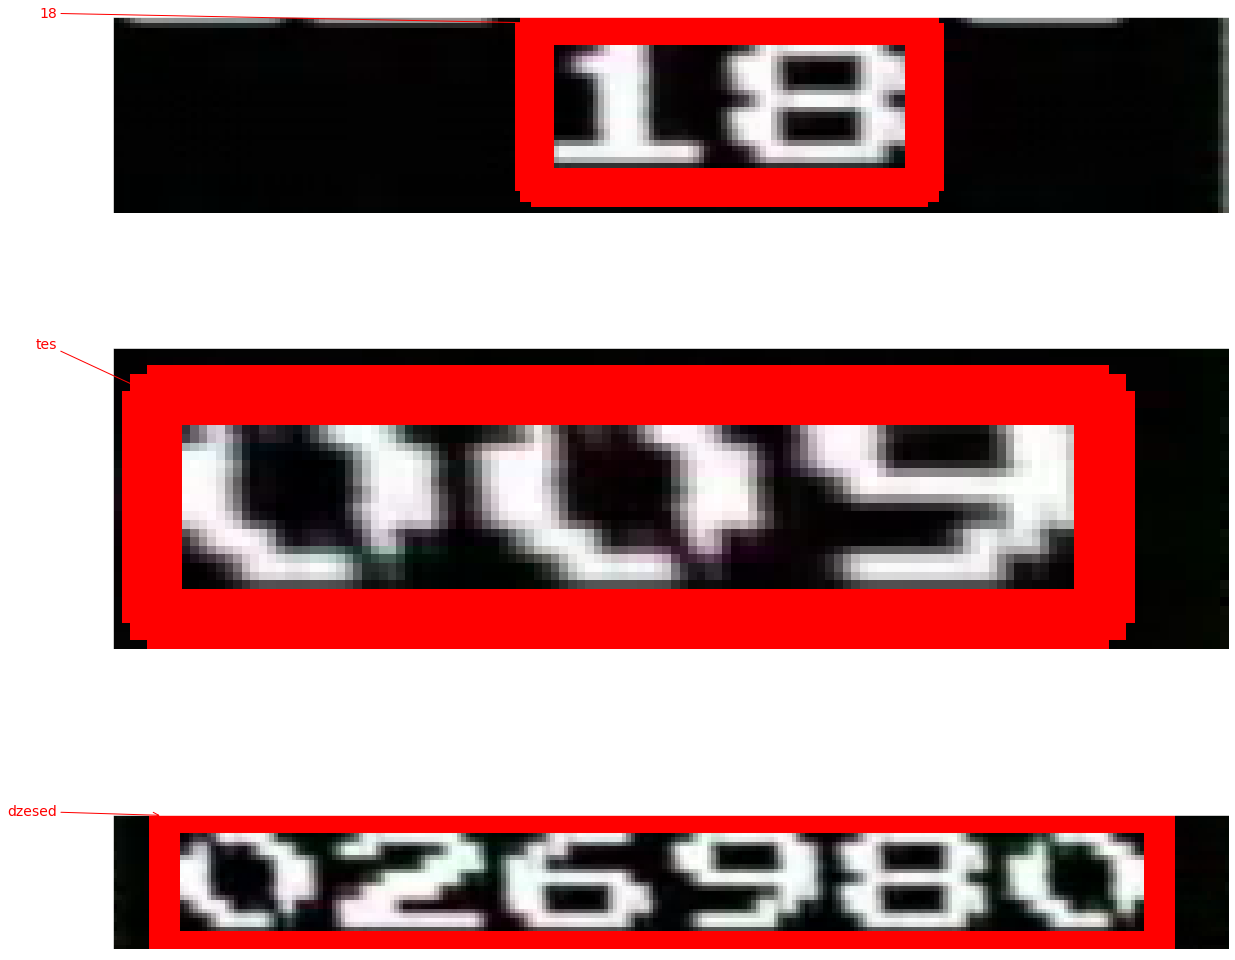

In [9]:
#Importing the library
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr will automatically download pretrained
# weights for the detector and recognizer.
pipeline = keras_ocr.pipeline.Pipeline()

# Get a set of three example images
frame_snips_color = Snips(**{key : img[(b.y)[0]:b.y[1],b.x[0]:b.x[1]] for key, b in regions.items()})
images = [
    # keras_ocr.tools.read(url) for url in [
    #     'https://upload.wikimedia.org/wikipedia/commons/thumb/b/b4/Notis_-_Gim_Nas_Stik_-_1834-08-16.png/255px-Notis_-_Gim_Nas_Stik_-_1834-08-16.png',
    #     'https://upload.wikimedia.org/wikipedia/commons/d/db/Vicent-van-Volkmer-Bienen-Aktivist-Demo-29.08.2020_Berlin_Covid-19_Pandemie.jpg'
    # ]
    frame_snips_color.level, frame_snips_color.lines, frame_snips_color.score
]

# Each list of predictions in prediction_groups is a list of
# (word, box) tuples.
prediction_groups = pipeline.recognize(images)

# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for ax, image, predictions in zip(axs, images, prediction_groups):
    keras_ocr.tools.drawAnnotations(image=image, predictions=predictions, ax=ax)

---
## Scratch

In [ ]:
# { key : np.fromfunction(lambda x, y: cv2.inRange(snips[key], 25,255)[x,y] , snips[key].shape, dtype = int) for key in snips.keys()}
# y = np.linspace(*regions["board"].y, 10, dtype = int)
# x = np.linspace(*regions["board"].x, 20, dtype = int)
# test_points = np.array(np.round(np.array(np.meshgrid(x, y)).transpose(),0), dtype=int)

# test_points_center = np.array(np.round(np.array(np.meshgrid(x_center[:-1], y_center[:-1])).transpose(),0), dtype=int)

# snip_values = { key : np.fromfunction(lambda x, y: snips[key][x,y] , snips[key].shape, dtype = int) for key in snips.keys()}